In [9]:
from ipfml import processing
from ipfml import utils
from ipfml import metrics
from PIL import Image
from scipy import signal
from skimage import color
import scipy.stats as stats
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from pylab import *
from skimage import data, io, color

import cv2

In [7]:
data_folder = "../fichiersSVD_light"

# Noise mask analysis on Synthesis Images 

## Utils functions definition

In [6]:
def compute_images_path(dict_data):
    
    all_images_path = []
    for cur_dict in dict_data:
        scene = cur_dict['name']
        prefix = cur_dict['prefix']
        indices = cur_dict['indices']

        scene_images_path = []
        for index in indices:
            path = os.path.join(data_folder, os.path.join(scene, prefix + index + ".png"))
            scene_images_path.append(path)
            
        all_images_path.append(scene_images_path)
            
    return all_images_path

In [5]:
def display_sv_data(dict_data, interval, all_images_path):
    
    sv_values = []
    plt.figure(figsize=(25, 20))
    begin, end = interval
    
    for id_dict, cur_dict in enumerate(dict_data):
        
        scene_name = cur_dict['name']
        image_indices = cur_dict['indices']
        scene_sv_values = []
    
        for id_img, img_path in enumerate(all_images_path[id_dict]):
            img = Image.open(img_path)
            print(img_path)
            
            blocks = processing.divide_in_blocks(img, (200, 200))
            block = np.array(blocks[0])
            
            if block.ndim == 3:
                U, s, V = processing.get_LAB_L_SVD(block)
            else:
                U, s, V = metrics.get_SVD(block)
                
            data = s[begin:end]
            plt.plot(data, label=scene_name + '_' + str(image_indices[id_img]))
            scene_sv_values.append(data)
            
        sv_values.append(scene_sv_values)

    plt.legend(fontsize=18)
    plt.show()
    return sv_values

In [14]:
def get_sv_data(cur_dict, interval, images_path_scene, norm=False, alpha=50, sigma=0.4):
    
    scene_name = cur_dict['name']
    image_indices = cur_dict['indices']
    zone = cur_dict['zone']
    scene_sv_values = []
    begin, end = interval
    
    plt.figure(figsize=(25, 15))
        
    for id_img, img_path in enumerate(images_path_scene):
        img = Image.open(img_path)
        
        img = processing.divide_in_blocks(img, (200, 200))[zone]
        
        # Convert to L canal
        img_grey = np.asarray(metrics.get_LAB_L(img), 'uint8')
        
        # Apply Gaussian blur on img
        blur_img = cv2.GaussianBlur(img_grey, (3,3), sigma)
        
        # get noise mask 
        noise_mask = img_grey - blur_img
        
        # reconstruct img
        new_img = img_grey - alpha * noise_mask
        
        s_new = metrics.get_SVD_s(new_img)
        data_new = s_new[begin:end]
        
        s = processing.get_LAB_L_SVD_s(img)
        data = s[begin:end]
        
        #Image.fromarray(new_img).show()
        
        if norm:
            data_new = utils.normalize_arr(data_new)
            data = utils.normalize_arr(data)
        
        plt.plot(data, label=scene_name + '_' + str(image_indices[id_img] + ' (new)'))
        plt.plot(data_new, label=scene_name + '_' + str(image_indices[id_img]))
        
        scene_sv_values.append(data)
    
    plt.legend(fontsize=18)
    plt.show()
    return scene_sv_values


## Scenes zones data

In [1]:
# start 00020 - ref 00900 - step 10
dict_appart = {'name': 'Appart1opt02', 
               'prefix': 'appartAopt_', 
               'indices': ["00020", "00200", "00300", "00900"],
               'zone': 6}

# start 00050 - ref 01200 - step 10
dict_cuisine = {'name': 'Cuisine01', 
               'prefix': 'cuisine01_', 
               'indices': ["00050", "00400", "01200"],
               'zone': 6}

# start 00020 - ref 00950 - step 10
dict_sdb_c = {'name': 'SdbCentre', 
               'prefix': 'SdB2_', 
               'indices': ["00020", "00400", "00950"],
               'zone': 6}

# start 00020 - ref 00950 - step 10
dict_sdb_d = {'name': 'SdbDroite', 
               'prefix': 'SdB2_D_', 
               'indices': ["00020", "00400", "00950"],
               'zone': 6}

In [4]:
all_dicts = [dict_appart, dict_cuisine, dict_sdb_c, dict_sdb_d]
interval = (30, 200)

In [10]:
images_path = compute_images_path(all_dicts)

In [11]:
scene_index = 0

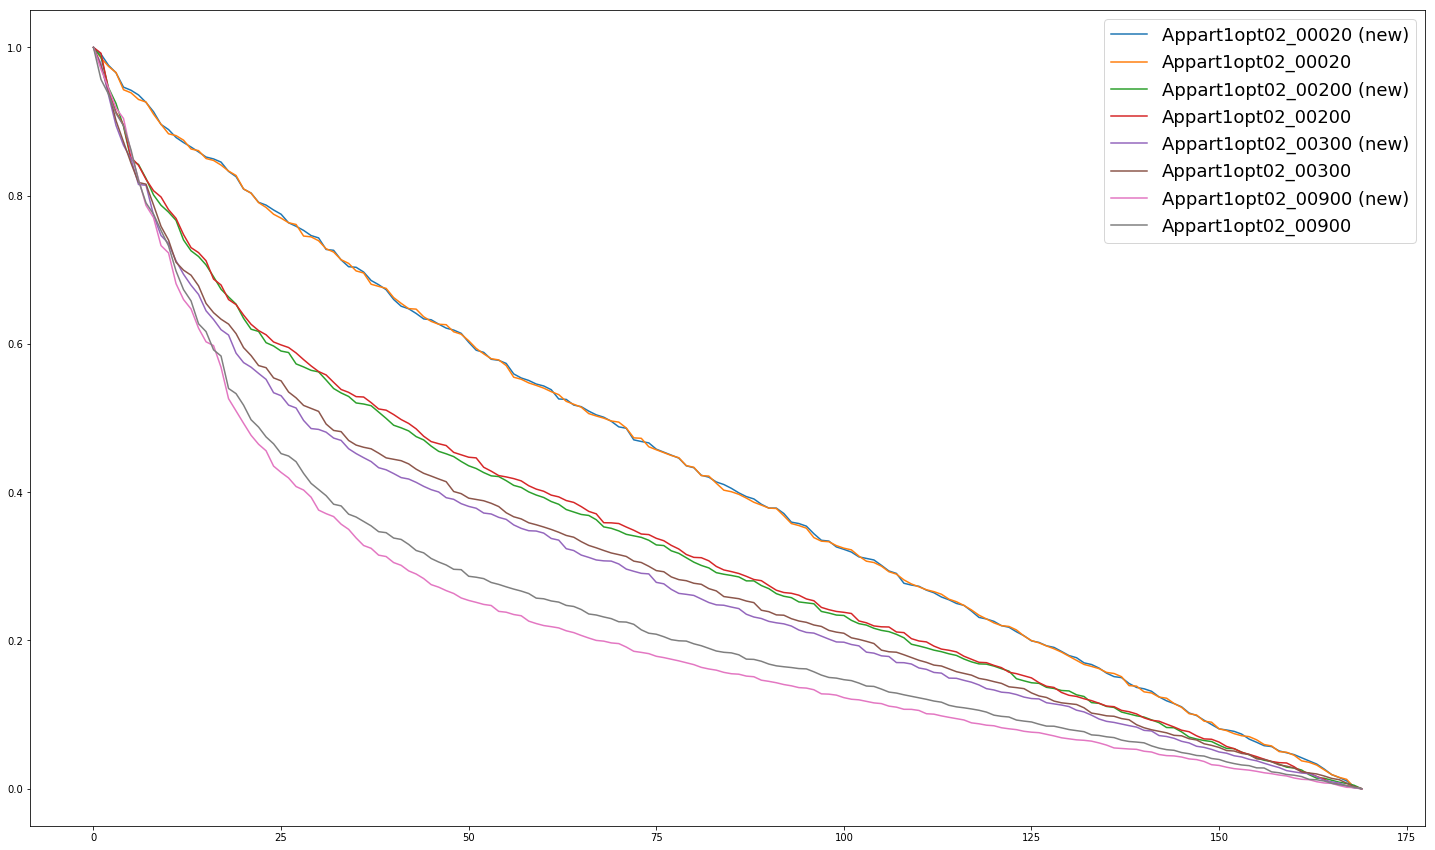

In [18]:
sv_values = get_sv_data(all_dicts[scene_index], interval, images_path[scene_index], norm=True, alpha=20, sigma=0.3)